In [1]:
import pandas as pd
import time
# Load the dataset
file_path = './clinicalData2.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,subject_id,stay_id,hadm_id,hospital_expire_flag,dod,gender,admission_age,hematocrit_min,hematocrit_max,hemoglobin_min,...,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,19452423,33252269,28656889,0,NaN,M,59,21.4,25.6,7.2,...,12.555556,36.50,36.89,36.667143,100.0,100.0,100.000000,151.0,180.0,163.800000
1,18607896,34323529,21419235,0,2129-09-01,M,59,28.4,30.7,9.6,...,16.760000,35.72,36.44,36.146667,88.0,100.0,94.600000,135.0,178.0,160.000000
2,19655491,32465570,23321342,1,2173-06-14,F,55,14.1,30.5,4.6,...,17.092593,35.17,36.39,35.806250,98.0,100.0,99.259259,76.0,144.0,103.750000
3,10666659,35745198,23457167,1,2143-12-02,F,53,26.0,31.9,8.5,...,20.615385,35.56,36.67,35.977143,93.0,99.0,95.347826,76.0,109.0,92.500000
4,12668169,31574288,23898774,1,2156-08-19,M,54,21.8,23.1,7.6,...,21.472973,34.40,36.89,36.075714,90.0,100.0,96.540541,85.0,103.0,95.666667


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing

# Convert 'dod' to binary (1 for deceased, 0 for alive)
#data['dod'] = data['dod'].notnull().astype(int)

# Dropping non-numeric or irrelevant columns
# features = data.drop(columns=['subject_id', 'stay_id', 'dod', 'icd_code'])
features = data.drop(columns=['subject_id', 'stay_id', 'hadm_id', 'dod'])

# Handling missing values
# For simplicity, filling missing values with the mean of the column
features = features.fillna(0)#features.mean()
#X = X.fillna(0)

# Encoding categorical variables
le = LabelEncoder()
features['gender'] = le.fit_transform(features['gender'])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Target variable
# target = data['dod']
target = data['dod'].notnull().astype(int)
#target = data['hospital_expire_flag']
#print(target)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

'''
# Training the SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions
#y_pred = svm_model.predict(X_test)
y_pred = svm_model.predict(X_train)

# Evaluation
#classification_report_output = classification_report(y_test, y_pred)
#confusion_matrix_output = confusion_matrix(y_test, y_pred)

classification_report_output = classification_report(y_train, y_pred)
confusion_matrix_output = confusion_matrix(y_train, y_pred)

print(classification_report_output)
print(confusion_matrix_output)

'''

"\n# Training the SVM classifier\nsvm_model = SVC(kernel='linear')\nsvm_model.fit(X_train, y_train)\n\n# Predictions\n#y_pred = svm_model.predict(X_test)\ny_pred = svm_model.predict(X_train)\n\n# Evaluation\n#classification_report_output = classification_report(y_test, y_pred)\n#confusion_matrix_output = confusion_matrix(y_test, y_pred)\n\nclassification_report_output = classification_report(y_train, y_pred)\nconfusion_matrix_output = confusion_matrix(y_train, y_pred)\n\nprint(classification_report_output)\nprint(confusion_matrix_output)\n\n"

### 法一：一般

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

postfix_all = []
fpr_all = []
tpr_all = []
roc_auc_all = []

mean_predicted_value_all = []
fraction_of_positives_all = []


def run_model(model, train_X, train_y, postfix=''):
    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=42)
    model.fit(train_X, train_y)
    pred_y = model.predict(val_X)
    prob_y = model.predict_proba(val_X)[:, 1]
    true_y = np.array(val_y)

    #print('Confusion Matrix:\n', confusion_matrix(true_y, pred_y).T)
    accuracy = accuracy_score(true_y, pred_y)
    precision = precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    f1 = f1_score(true_y, pred_y)
    print('\nAccuracy, Precision, Recall, F1:')
    print(f'{accuracy:4f}, {precision:4f}, {recall:4f}, {f1:4f}\n')
    
    # Creating a confusion matrix plot
    #print("true_y: ", true_y.shape)
    #print("pred_y: ", pred_y.shape)
    #print(pred_y)
    cm = confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    # ROC
    print('-'*30)
    fpr, tpr, thresholds = roc_curve(true_y, prob_y)
    # Compute the sensitivity (True Positive Rate) and specificity (1 - False Positive Rate)
    sensitivity = tpr  # True Positive Rate
    specificity = 1 - fpr  # 1 - False Positive Rate

    # Compute Youden's J statistic
    youden_j = sensitivity + specificity - 1

    # Find the optimal threshold
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    print(optimal_idx)
    print(optimal_threshold)

    # Predict probabilities
    y_pred = (prob_y >= optimal_threshold).astype(bool) # set threshold as 0.3
    #y_pred = model.predict(X_test)

    # Compute ROC curve
    roc_auc = roc_auc_score(true_y, prob_y)
    print("roc_auc: ", roc_auc)
    accuracy = accuracy_score(true_y, y_pred)
    precision = precision_score(true_y, y_pred)
    recall = recall_score(true_y, y_pred)
    f1 = f1_score(true_y, y_pred)
    auc = roc_auc_score(true_y, y_pred)
    print('\nAccuracy, Precision, Recall, F1:')
    print(f'{accuracy:4f}, {precision:4f}, {recall:4f}, {f1:4f}\n')

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Logistic Regression')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calibration plot
    fraction_of_positives, mean_predicted_value = calibration_curve(true_y, prob_y, n_bins=10)

    # Plotting the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="LogisticRegression")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration plot (reliability curve)')
    plt.legend()
    plt.show()
    return postfix, fpr, tpr, roc_auc, fraction_of_positives, mean_predicted_value
    
    #pred_test_y = model.predict(test_X)
    #pd.DataFrame({'id': range(len(pred_test_y)), 'label': pred_test_y}).to_csv('submission_' + postfix + '.csv', index=False)


Accuracy, Precision, Recall, F1:
0.773874, 0.832344, 0.802575, 0.817189



/home/cnelabai/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


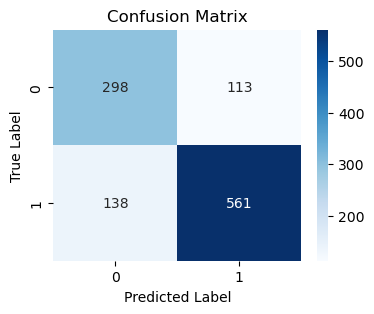

------------------------------
34
0.7838242135692576
roc_auc:  0.8635589946012552

Accuracy, Precision, Recall, F1:
0.750450, 0.960699, 0.629471, 0.760588



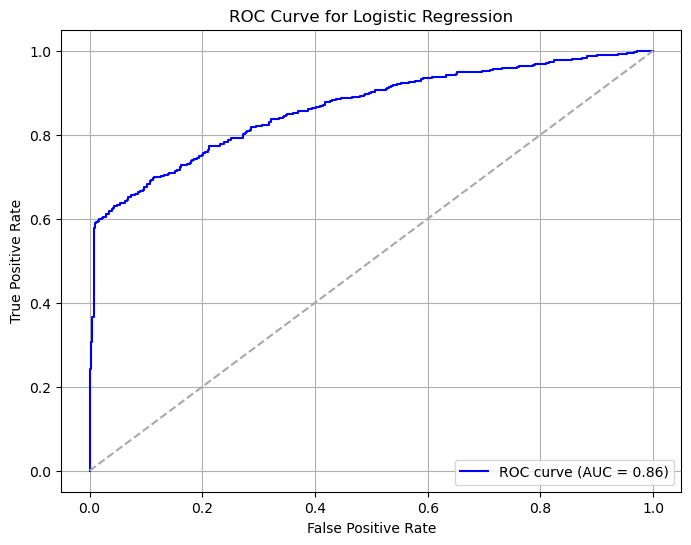

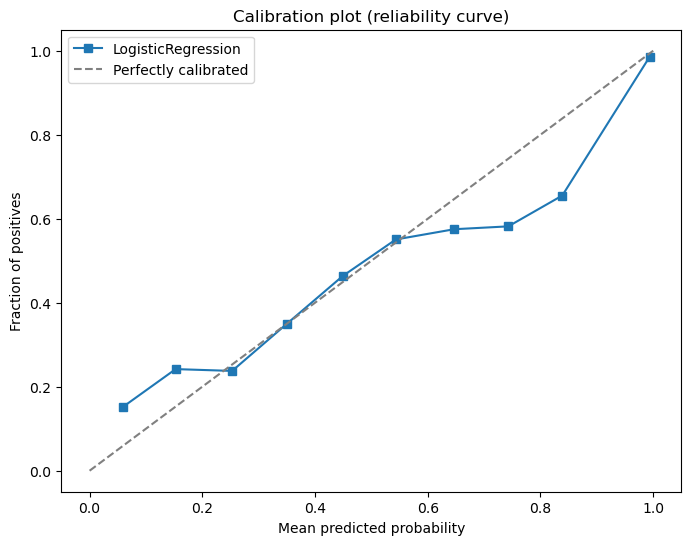

------------------------------


In [4]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(random_state=1, multi_class='multinomial', solver='saga')

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(logistic, features_scaled, target, 'LR')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)

print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')
# postfix_all[0], fpr_all[0], tpr_all[0], roc_auc_all[0] 



Accuracy, Precision, Recall, F1:
0.768468, 0.824047, 0.804006, 0.813903



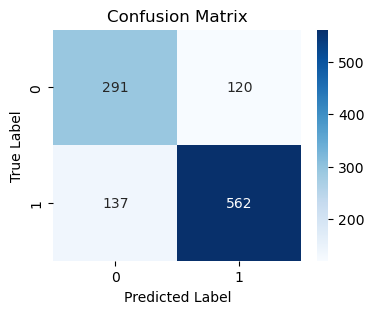

------------------------------
42
0.7016117739438505
roc_auc:  0.8547768971314599

Accuracy, Precision, Recall, F1:
0.761261, 0.946502, 0.658083, 0.776371



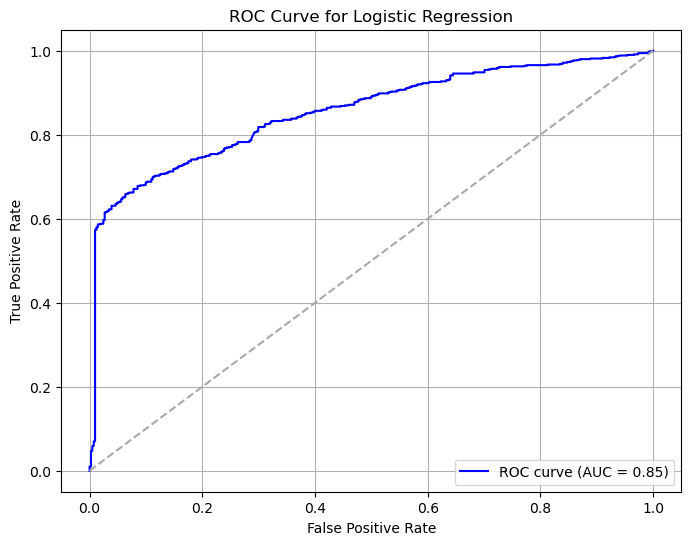

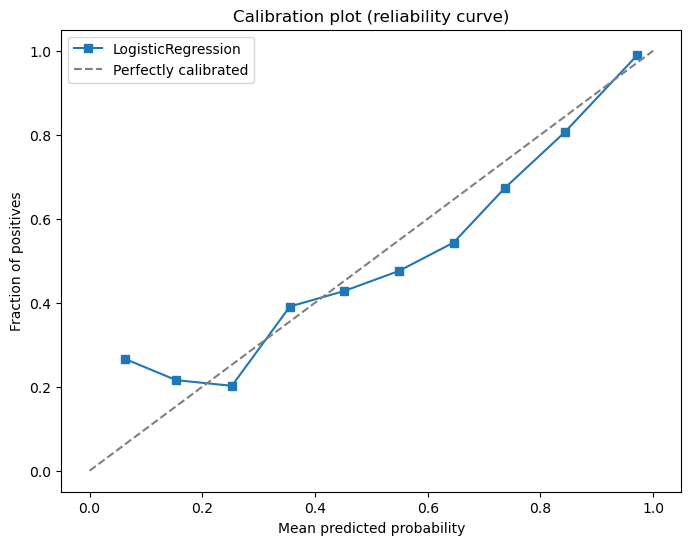

------------------------------


In [5]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC, SVC

svm_model = SVC(kernel='linear', probability=True)
#svm_model = SklearnClassifier(SVC(kernel='linear',probability=True))

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(svm_model, features_scaled, target, 'SVM')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')


Accuracy, Precision, Recall, F1:
0.724324, 0.772538, 0.796853, 0.784507



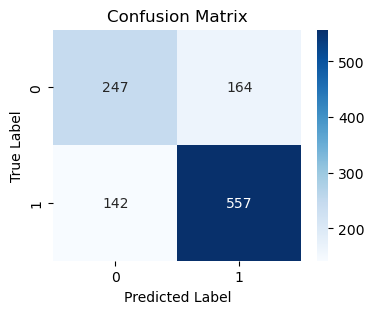

------------------------------
1
1.0
roc_auc:  0.6989129413238934

Accuracy, Precision, Recall, F1:
0.724324, 0.772538, 0.796853, 0.784507



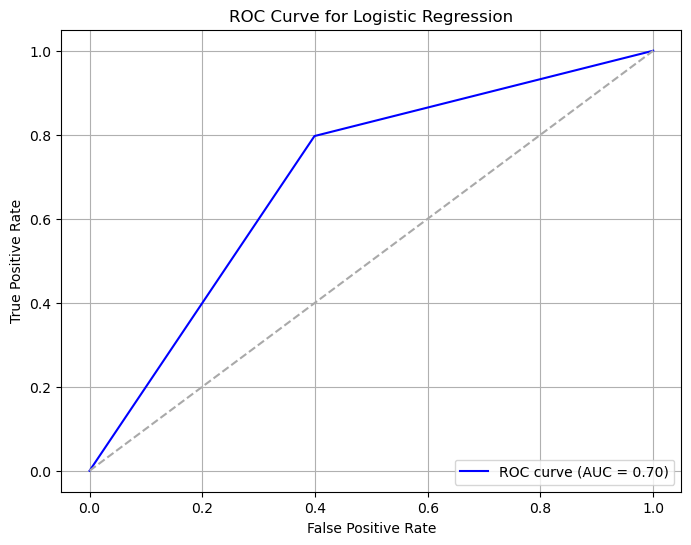

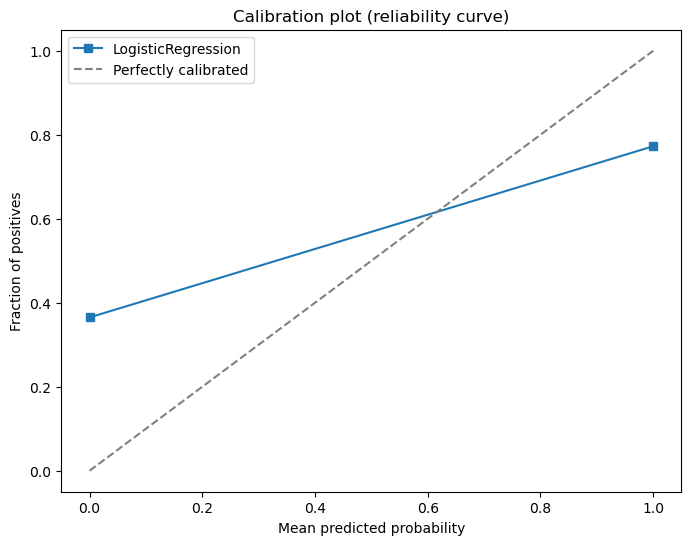

------------------------------


In [6]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(dt_model, features_scaled, target, 'DT')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')


Accuracy, Precision, Recall, F1:
0.758559, 0.781699, 0.855508, 0.816940



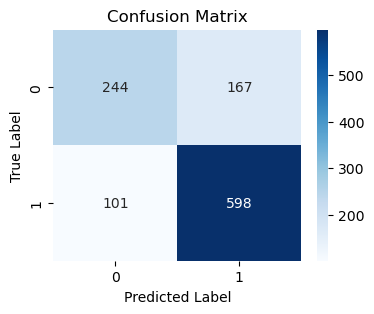

------------------------------
28
0.71
roc_auc:  0.8641263675253839

Accuracy, Precision, Recall, F1:
0.764865, 0.976087, 0.642346, 0.774806



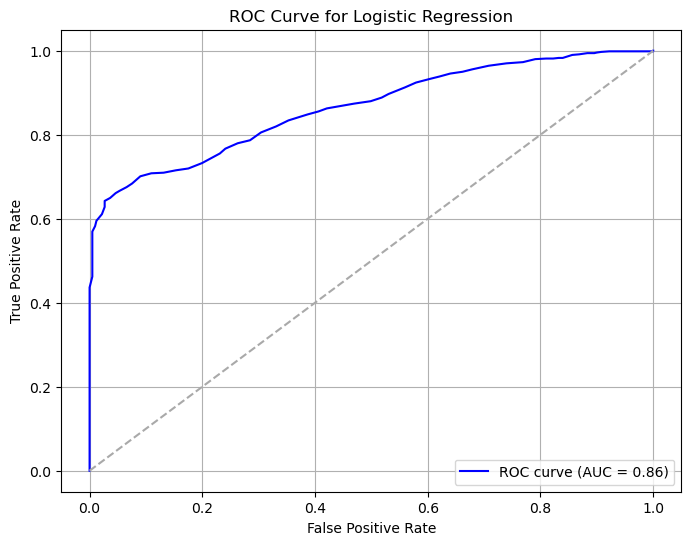

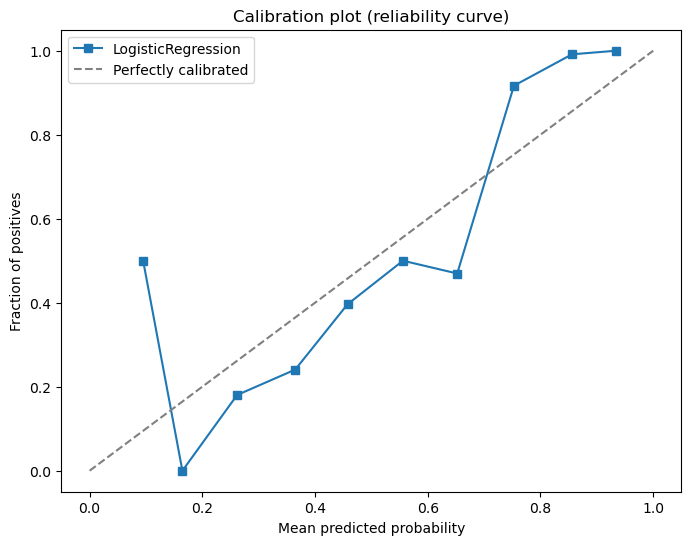

------------------------------


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(rf_model, features_scaled, target, 'RF')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')


Accuracy, Precision, Recall, F1:
0.668468, 0.738817, 0.732475, 0.735632



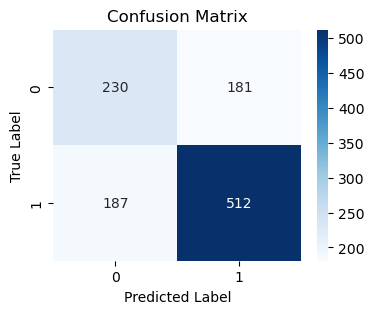

------------------------------
3
0.6
roc_auc:  0.6968035671397096

Accuracy, Precision, Recall, F1:
0.668468, 0.738817, 0.732475, 0.735632



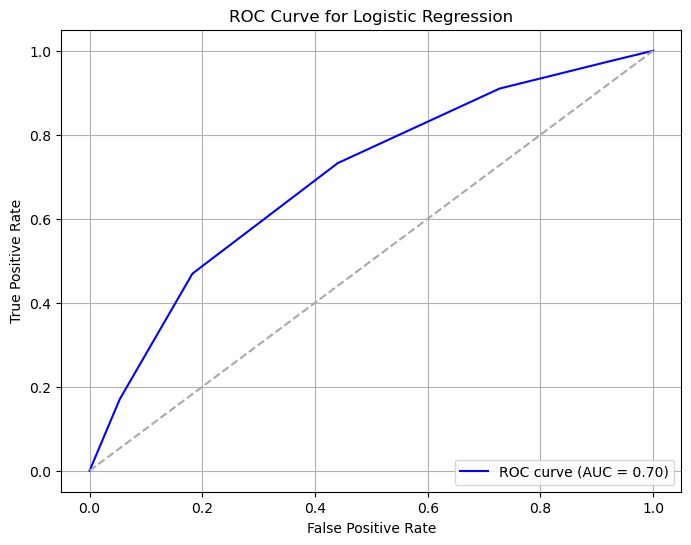

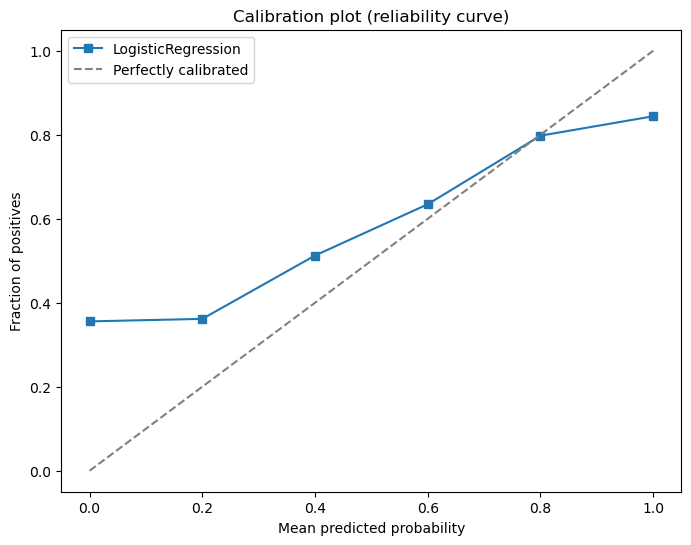

------------------------------


In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(knn_model, features_scaled, target, 'KNN')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')


Accuracy, Precision, Recall, F1:
0.726126, 0.877629, 0.656652, 0.751227



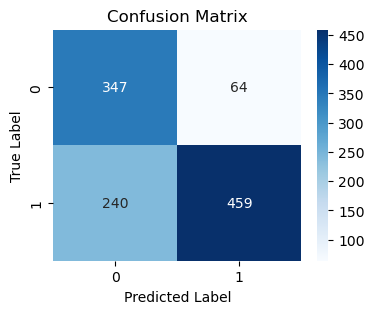

------------------------------
1
1.0
roc_auc:  0.8059445366860548

Accuracy, Precision, Recall, F1:
0.738739, 0.949451, 0.618026, 0.748700



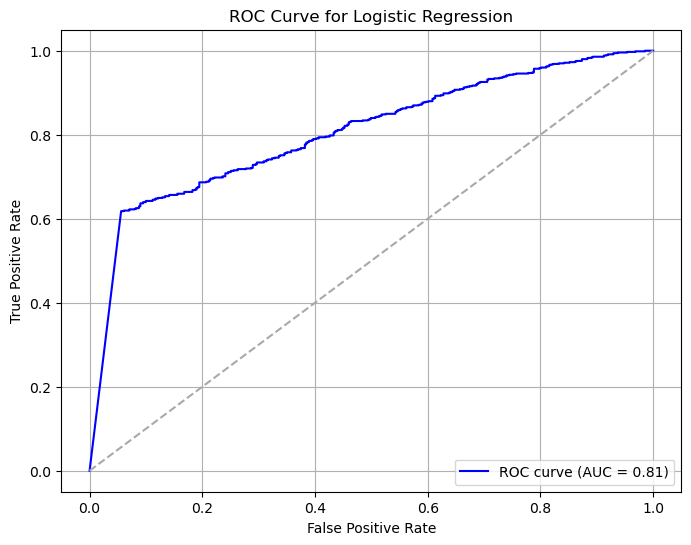

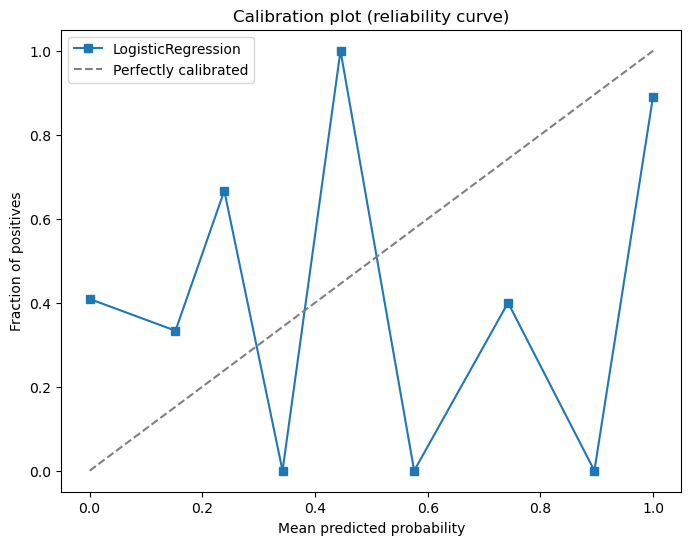

------------------------------


In [9]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(nb_model, features_scaled, target, 'GNB')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)
#run_model2(logistic, features_scaled, target, 'logistic')


Accuracy, Precision, Recall, F1:
0.779279, 0.831871, 0.814020, 0.822849



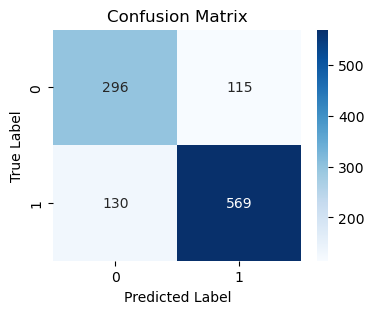

------------------------------
24
0.8179039
roc_auc:  0.8764902241297091

Accuracy, Precision, Recall, F1:
0.763964, 0.973970, 0.642346, 0.774138



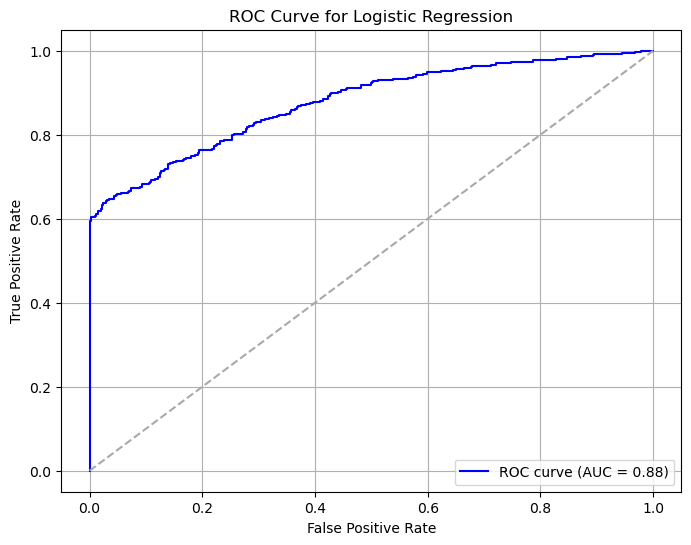

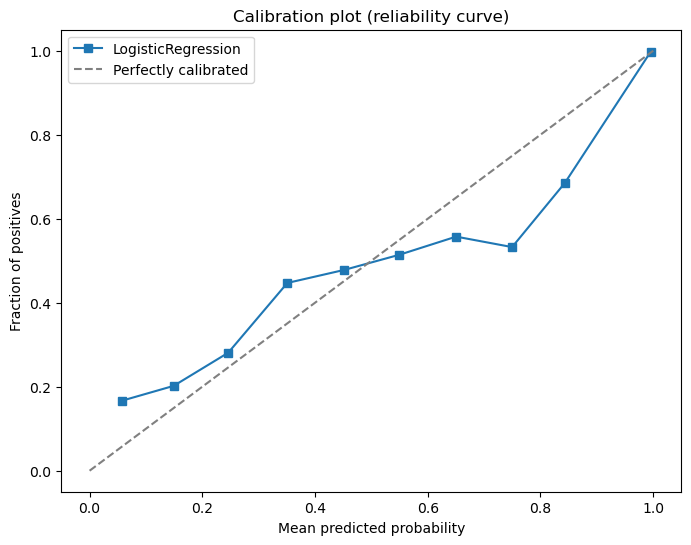

------------------------------


In [10]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_lambda=1,  # Default L2 regularization
    reg_alpha=0   # Default L1 regularization
)

postfix, fpr, tpr, roc_auc, fop, mpv = run_model(xgb_clf, features_scaled, target, 'XGBoost')
postfix_all.append(postfix)
fpr_all.append(fpr)
tpr_all.append(tpr)
roc_auc_all.append(roc_auc)
mean_predicted_value_all.append(mpv)
fraction_of_positives_all.append(fop)
print('-'*30)

['LR', 'SVM', 'DT', 'RF', 'KNN', 'GNB', 'XGBoost']


/tmp/ipykernel_198017/1821546818.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fpr_all = np.array(fpr_all)
/tmp/ipykernel_198017/1821546818.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tpr_all = np.array(tpr_all)


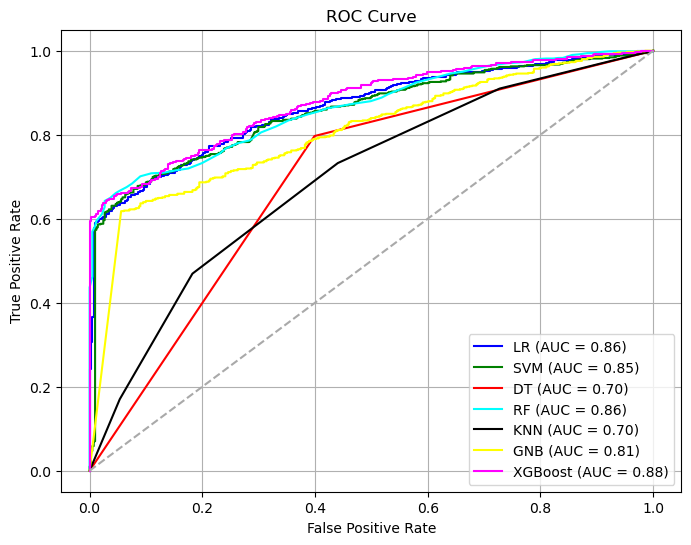

In [11]:
print(postfix_all)
fpr_all = np.array(fpr_all)
tpr_all = np.array(tpr_all)
roc_auc_all = np.array(roc_auc_all)
colors = [
    'blue',      # Blue color
    'green',     # Green color
    'red',       # Red color
    'cyan',      # Cyan color
    'black',   # Magenta color
    'yellow',    # Yellow color
    'magenta'      # Black color
]

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr_all[i], tpr_all[i], color=colors[i], label=f'{str(postfix_all[i])} (AUC = {roc_auc_all[i]:.2f})')
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

['LR', 'SVM', 'DT', 'RF', 'KNN', 'GNB', 'XGBoost']


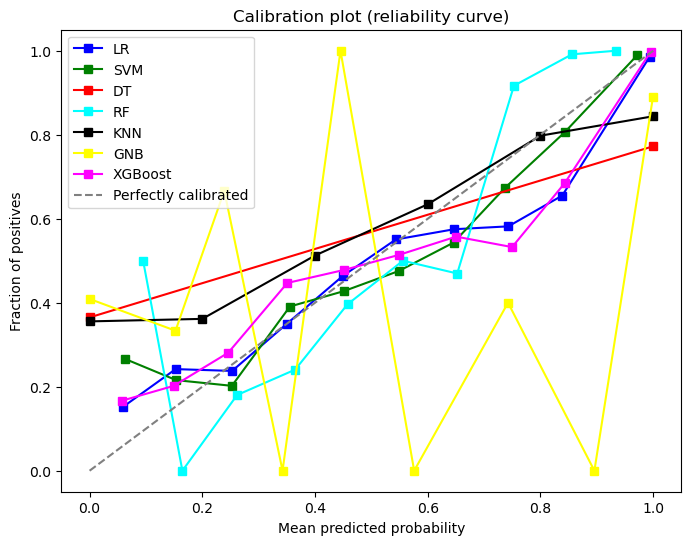

In [14]:
print(postfix_all)
mean_predicted_value_all = np.array(mean_predicted_value_all)
fraction_of_positives_all = np.array(fraction_of_positives_all)
colors = [
    'blue',      # Blue color
    'green',     # Green color
    'red',       # Red color
    'cyan',      # Cyan color
    'black',   # Magenta color
    'yellow',    # Yellow color
    'magenta'      # Black color
]

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
#plt.plot(mean_predicted_value_all[i], fraction_of_positives_all[i], "s-", color=colors[i], label=str(postfix_all[i]))
for i in range(7):
    plt.plot(mean_predicted_value_all[i], fraction_of_positives_all[i], "s-", color=colors[i], label=str(postfix_all[i]))
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot (reliability curve)')
plt.legend()
plt.show()

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

for i in range(20):
    i = i+10
    pre_time = time.time()
    xgb_clf = xgb.XGBClassifier(
        n_estimators=i*10,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        reg_lambda=1,  # Default L2 regularization
        reg_alpha=0   # Default L1 regularization
    )


    xgb_clf.fit(X_train, y_train)

    spend_time = time.time() - pre_time
    print("n_estimators:", i*10, "spend time(sec):", spend_time)
    # Evaluate
    predictions = xgb_clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    precision = precision_score(y_test, predictions)
    print("Precision: %.2f%%" % (precision * 100.0))
    recall = recall_score(y_test, predictions)
    print("Recall: %.2f%%" % (recall * 100.0))
    f1 = f1_score(y_test, predictions)
    print("F1: %.2f%%" % (f1 * 100.0))

n_estimators: 100 spend time(sec): 0.259824275970459
Accuracy: 73.38%
Precision: 75.18%
Recall: 87.10%
F1: 80.71%
n_estimators: 110 spend time(sec): 0.2623720169067383
Accuracy: 73.24%
Precision: 75.23%
Recall: 86.68%
F1: 80.55%
n_estimators: 120 spend time(sec): 0.1459331512451172
Accuracy: 72.43%
Precision: 74.68%
Recall: 86.05%
F1: 79.96%
n_estimators: 130 spend time(sec): 0.2884690761566162
Accuracy: 73.24%
Precision: 75.23%
Recall: 86.68%
F1: 80.55%
n_estimators: 140 spend time(sec): 0.19928932189941406
Accuracy: 72.43%
Precision: 74.50%
Recall: 86.47%
F1: 80.04%
n_estimators: 150 spend time(sec): 0.2438650131225586
Accuracy: 72.70%
Precision: 74.77%
Recall: 86.47%
F1: 80.20%
n_estimators: 160 spend time(sec): 0.2135753631591797
Accuracy: 73.11%
Precision: 75.28%
Recall: 86.26%
F1: 80.39%
n_estimators: 170 spend time(sec): 0.260542631149292
Accuracy: 72.97%
Precision: 75.23%
Recall: 86.05%
F1: 80.28%
n_estimators: 180 spend time(sec): 0.43796730041503906
Accuracy: 72.97%
Precision

In [6]:
import pandas as pd
import numpy as np

# Your array with dates and NaN values
dod = [np.nan, '2129-09-01', np.nan, '2143-12-02']
dod = data['dod']

# Convert to pandas Series
dod_series = pd.Series(dod)

# Convert non-null dates to 1 and NaNs to 0
# Here, notnull() checks for non-NaN (i.e., date) entries
dod_binary1 = data['dod'].notnull().astype(int)

print(dod_binary1)
dod_binary = dod_series.notnull().astype(int)

# This will give you a Pandas Series. If you need a list:
dod_binary_list = dod_binary.tolist()

print(dod_binary_list)  # Output will be [0, 1, 0, 1]


0       0
1       1
2       1
3       1
4       1
       ..
3692    1
3693    1
3694    0
3695    0
3696    0
Name: dod, Length: 3697, dtype: int64
[0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### 法二：k-fold cross-validation + voting

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from scipy.stats import mode

def run_model2(model, _train_X, _train_y, postfix=''):
    # 進行 k-折交叉驗證，並計算 F1 分數
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    test_predictions = []
    f1_scores = []

    for train_index, val_index in kfold.split(_train_X):
        train_X, val_X = _train_X[train_index], _train_X[val_index]
        train_y, val_y = _train_y[train_index], _train_y[val_index]

        # 模型訓練
        model.fit(train_X, train_y)
        
        # 驗證模型並計算 F1 分數
        pred_y = model.predict(val_X)
        print('Fold Confusion Matrix:\n', confusion_matrix(val_y, pred_y).T)
        f1 = f1_score(val_y, pred_y)
        f1_scores.append(f1)
        print(f"Fold F1 Score: {f1:.4f}\n")

        # 在測試集上進行預測並儲存結果
        #test_pred = model.predict(test_X)
        #test_predictions.append(test_pred)

    # 計算 F1 分數的平均值
    average_f1_score = np.mean(f1_scores)
    print(f"Average F1 Score: {average_f1_score:.4f}")

    # 使用投票機制來決定最終預測
    #final_predictions = mode(test_predictions)[0]
    #pd.DataFrame({'id': range(len(final_predictions)), 'label': final_predictions}).to_csv('submission_' + postfix + '_kfold.csv', index=False)